In [ ]:
import geopandas as gpd
import os
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from ipywidgets import VBox, HTML
import geemap
import ee

In [2]:
ee.Authenticate()
ee.Initialize(project='twoearthengineproject')

In [80]:
folder_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\river_channel"
shp_1990 = gpd.read_file(os.path.join(folder_path, "river_channel_1990.shp"))
shp_2000 = gpd.read_file(os.path.join(folder_path, "river_channel_2000.shp"))
shp_2010 = gpd.read_file(os.path.join(folder_path, "river_channel_2010.shp"))
shp_2020 = gpd.read_file(os.path.join(folder_path, "river_channel_2020.shp"))
shp_2024 = gpd.read_file(os.path.join(folder_path, "river_channel_2024.shp"))

aoi_gdf = gpd.read_file(os.path.join(folder_path, "drawn_feature2_.shp")).to_crs("EPSG:4326")


In [57]:
import geemap
import ee
from ipyleaflet import ScaleControl, WidgetControl
from ipywidgets import HTML
import os

In [69]:
aoi_path = os.path.join(folder_path, "drawn_feature2_.shp")

years = [1990, 2000, 2010, 2020, 2024]  # JRC available to 2020; 2024 uses optional fallback below
palette_multi = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

# ----------------------------------------------------
# 1) Read AOI shapefile and convert to EE geometry
# ----------------------------------------------------
aoi_gdf = gpd.read_file(aoi_path)

# fix invalid geometries if needed
aoi_gdf["geometry"] = aoi_gdf["geometry"].buffer(0)
aoi_diss = aoi_gdf.dissolve()  # single-part AOI
aoi = geemap.gdf_to_ee(aoi_diss)

# ----------------------------------------------------
# 2) Helper: Get JRC water mask for a given year (1984–2020)
#    waterClass codes (JRC): 0 No data, 1 Not water, 2 Water, 3 Seasonal water
# ----------------------------------------------------
def get_jrc_water_mask(year, region):
    year = int(year)
    if year > 2020:
        return None  # JRC stops at 2020

    jrc = ee.ImageCollection("JRC/GSW1_4/YearlyHistory") \
            .filterBounds(region) \
            .filter(ee.Filter.eq('year', year)) \
            .first()

    water_class = jrc.select('waterClass')
    # keep both perennial (2) and seasonal (3)
    water_mask = water_class.eq(2).Or(water_class.eq(3)).selfMask()
    return water_mask.clip(region)

# ----------------------------------------------------
# 3) OPTIONAL Fallback for 2024 via Landsat (simple MNDWI)
# ----------------------------------------------------
def landsat_mndwi_water(year, region):
    year = int(year)
    if year >= 2013:
        col_id = 'LANDSAT/LC08/C02/T1_L2'
        bands = ['SR_B3','SR_B6','QA_PIXEL']   # green, swir1, QA
        names = ['green','swir','QA_PIXEL']
    elif year >= 1999:
        col_id = 'LANDSAT/LE07/C02/T1_L2'
        bands = ['SR_B2','SR_B5','QA_PIXEL']
        names = ['green','swir','QA_PIXEL']
    else:
        col_id = 'LANDSAT/LT05/C02/T1_L2'
        bands = ['SR_B2','SR_B5','QA_PIXEL']
        names = ['green','swir','QA_PIXEL']

    def mask_clouds(img):
        qa = img.select('QA_PIXEL')
        # simple cloud mask bit 5 (cloud) off
        return img.updateMask(qa.bitwiseAnd(1 << 5).eq(0))

    def add_mndwi(img):
        g = img.select('green')
        s = img.select('swir')
        mndwi = g.subtract(s).divide(g.add(s)).rename('mndwi')
        return img.addBands(mndwi)

    col = (ee.ImageCollection(col_id)
           .filterBounds(region)
           .filterDate(f'{year}-10-01', f'{year}-12-31')  # non-monsoon
           .select(bands, names)
           .map(mask_clouds)
           .map(add_mndwi))

    med = col.median()
    water = med.select('mndwi').gt(0.05).selfMask()  # threshold tweakable
    return water.clip(region)

# ----------------------------------------------------
# 4) Build water masks by year (JRC until 2020; Landsat fallback for 2024)
# ----------------------------------------------------
water_masks = {}
for y in years:
    wm = get_jrc_water_mask(y, aoi)
    if wm is None:
        # fallback for years beyond 2020
        wm = landsat_mndwi_water(y, aoi)
        print(f"Year {y}: using Landsat fallback (JRC not available).")
    else:
        print(f"Year {y}: JRC YearlyHistory water mask ready.")
    water_masks[y] = wm


'''def export_water_vectors(water_masks, aoi, folder="Water_mask_vector", scale=30):
    """
    Convert yearly water mask raster to vector polygons and export as SHP.
    
    Parameters:
    - water_masks: dict {year: ee.Image}
    - aoi: ee.Geometry / ee.FeatureCollection
    - folder: Google Drive folder name
    - scale: resolution for raster to vector conversion
    """
    for year, img in water_masks.items():
        # Convert water mask (0/1) to vector polygons
        vectors = img.mask(img).reduceToVectors(
            geometry=aoi,
            scale=scale,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='water',
            bestEffort=True,
            maxPixels=1e13
        )

        # Export each year’s vector polygons as SHP
        task = ee.batch.Export.table.toDrive(
            collection=vectors,
            description=f"water_vector_{year}",
            folder=folder,
            fileFormat="SHP",
            fileNamePrefix=f"water_vector_{year}"
        )
        task.start()
        print(f"Export started: water_vector_{year}.shp")
# After filling water_masks dict
# After building water_masks dict
export_water_vectors(water_masks, aoi, folder="Water_mask_vector")'''
# ----------------------------------------------------
# 5) Visualize: single map with all years + legend
# ----------------------------------------------------
Map = geemap.Map()
Map.centerObject(aoi, 10)

for i, y in enumerate(years):
    Map.addLayer(water_masks[y], {'palette': palette_multi[i], 'min':0, 'max':1}, f'River {y}')

# Legend: year -> color
legend_dict = {str(y): palette_multi[i] for i, y in enumerate(years)}
Map.add_legend(title="Legend", legend_dict=legend_dict)
from ipyleaflet import ScaleControl

Map.add_control(ScaleControl(position='bottomleft'))
# Create a north arrow widget (using Unicode ↑)
from ipywidgets import HTML
from ipyleaflet import WidgetControl

# Create north arrow widget
north_arrow = HTML("<div style='font-size:20px; text-align:center;'>↑<br>North</div>")

# Add to map as a widget control
north_arrow_control = WidgetControl(widget=north_arrow, position='topright')
Map.add_control(north_arrow_control)
Map.add_html(north_arrow, position='topright')
Map.add_html()
Map.addLayer(aoi, {'color':'black'}, 'AOI')
Map
# --- Export map as HTML ---
output_html = "koshi_water_map_improved.html"
Map.to_html(output_html, title="Koshi Water Map", width="100%", height="700px")
print(f"Interactive HTML map saved -> {output_html}")


Year 1990: JRC YearlyHistory water mask ready.
Year 2000: JRC YearlyHistory water mask ready.
Year 2010: JRC YearlyHistory water mask ready.
Year 2020: JRC YearlyHistory water mask ready.
Year 2024: using Landsat fallback (JRC not available).


Interactive HTML map saved -> koshi_water_map_improved.html


In [82]:
import selenium
aoi_path = os.path.join(folder_path, "drawn_feature2_.shp")

years = [1990, 2000, 2010, 2020, 2024]  # JRC available to 2020; 2024 uses optional fallback below
palette_multi = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

# ----------------------------------------------------
# 1) Read AOI shapefile and convert to EE geometry
# ----------------------------------------------------
aoi_gdf = gpd.read_file(aoi_path)

# fix invalid geometries if needed
aoi_gdf["geometry"] = aoi_gdf["geometry"].buffer(0)
aoi_diss = aoi_gdf.dissolve()  # single-part AOI
aoi = geemap.gdf_to_ee(aoi_diss)

# ----------------------------------------------------
# 2) Helper: Get JRC water mask for a given year (1984–2020)
#    waterClass codes (JRC): 0 No data, 1 Not water, 2 Water, 3 Seasonal water
# ----------------------------------------------------
def get_jrc_water_mask(year, region):
    year = int(year)
    if year > 2020:
        return None  # JRC stops at 2020

    jrc = ee.ImageCollection("JRC/GSW1_4/YearlyHistory") \
            .filterBounds(region) \
            .filter(ee.Filter.eq('year', year)) \
            .first()

    water_class = jrc.select('waterClass')
    # keep both perennial (2) and seasonal (3)
    water_mask = water_class.eq(2).Or(water_class.eq(3)).selfMask()
    return water_mask.clip(region)

# ----------------------------------------------------
# 3) OPTIONAL Fallback for 2024 via Landsat (simple MNDWI)
# ----------------------------------------------------
def landsat_mndwi_water(year, region):
    year = int(year)
    if year >= 2013:
        col_id = 'LANDSAT/LC08/C02/T1_L2'
        bands = ['SR_B3','SR_B6','QA_PIXEL']   # green, swir1, QA
        names = ['green','swir','QA_PIXEL']
    elif year >= 1999:
        col_id = 'LANDSAT/LE07/C02/T1_L2'
        bands = ['SR_B2','SR_B5','QA_PIXEL']
        names = ['green','swir','QA_PIXEL']
    else:
        col_id = 'LANDSAT/LT05/C02/T1_L2'
        bands = ['SR_B2','SR_B5','QA_PIXEL']
        names = ['green','swir','QA_PIXEL']

    def mask_clouds(img):
        qa = img.select('QA_PIXEL')
        # simple cloud mask bit 5 (cloud) off
        return img.updateMask(qa.bitwiseAnd(1 << 5).eq(0))

    def add_mndwi(img):
        g = img.select('green')
        s = img.select('swir')
        mndwi = g.subtract(s).divide(g.add(s)).rename('mndwi')
        return img.addBands(mndwi)

    col = (ee.ImageCollection(col_id)
           .filterBounds(region)
           .filterDate(f'{year}-10-01', f'{year}-12-31')  # non-monsoon
           .select(bands, names)
           .map(mask_clouds)
           .map(add_mndwi))

    med = col.median()
    water = med.select('mndwi').gt(0.05).selfMask()  # threshold tweakable
    return water.clip(region)

# ----------------------------------------------------
# 4) Build water masks by year (JRC until 2020; Landsat fallback for 2024)
# ----------------------------------------------------
water_masks = {}
for y in years:
    wm = get_jrc_water_mask(y, aoi)
    if wm is None:
        # fallback for years beyond 2020
        wm = landsat_mndwi_water(y, aoi)
        print(f"Year {y}: using Landsat fallback (JRC not available).")
    else:
        print(f"Year {y}: JRC YearlyHistory water mask ready.")
    water_masks[y] = wm

# --- Create Map ---
Map = geemap.Map()
Map.centerObject(aoi, 10)

# Add multi-year water layers with semi-transparency
for i, y in enumerate(years):
    Map.addLayer(
        water_masks[y],
        {'palette': palette_multi[i], 'min': 0, 'max': 1, 'opacity': 0.5},
        f'River {y}'
    )

# Add AOI boundary
Map.addLayer(aoi, {'color': 'black'}, 'AOI')

# Add built-in legend (works in exported HTML)
legend_dict = {str(y): palette_multi[i] for i, y in enumerate(years)}
Map.add_legend(title="Legend", legend_dict=legend_dict)

# Add scale bar
Map.add_control(ScaleControl(position='bottomleft'))

# Add north arrow as HTML overlay
north_arrow_html = """
<div style="
position: absolute; 
top: 10px; right: 10px; 
font-size: 24px; 
font-weight: bold; 
background-color: rgba(255,255,255,0.7); 
padding: 5px; 
border-radius: 5px;
text-align: center;
">↑<br>North</div>
"""
Map.add_html(north_arrow_html, position='topright')

# --- Export map as HTML ---
output_html = "koshi_water_map_improved.html"
Map.to_html(output_html, title="Koshi Water Map", width="100%", height="700px")
print(f"Interactive HTML map saved -> {output_html}")

# Display map
Map



DataSourceError: G:\learn\python_works\Work_projects\Koshi_chetan\chetan_cas\works\data\outputs\drawn_feature2_.shp: No such file or directory

In [63]:
# --- Parameters ---
years = [1990, 2000, 2010, 2020, 2024]
palette_multi = ['blue', 'green', 'orange', 'purple', 'cyan']
folder_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks"
output_html = "koshi_water_map_improved.html"

# AOI (replace with your own FeatureCollection)
aoi = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM0_NAME', 'Nepal'))

# Example water masks (replace with your ee.Image objects)
water_masks = {y: ee.Image("JRC/GSW1_3/GlobalSurfaceWater").select('occurrence') for y in years}

# --- Create Map ---
Map = geemap.Map()
Map.centerObject(aoi, 7)
Map.addLayer(aoi, {'color': 'black'}, 'AOI')

# --- Add water layers with transparency ---
for i, y in enumerate(years):
    Map.addLayer(
        water_masks[y], 
        {'palette': palette_multi[i], 'min': 0, 'max': 100, 'opacity': 0.5}, 
        f'Water {y}'
    )

# --- Add a built-in legend (works in HTML export) ---
legend_dict = {str(y): palette_multi[i] for i, y in enumerate(years)}
Map.add_legend(title="Water by Year", legend_dict=legend_dict)

# --- Add scale bar using ipyleaflet ---
Map.add_control(ScaleControl(position='bottomleft'))

# --- Add north arrow (simple HTML overlay) ---
north_arrow_html = """
<div style="
position: absolute; 
top: 10px; right: 10px; 
font-size: 24px; 
font-weight: bold; 
background-color: rgba(255,255,255,0.7); 
padding: 5px; 
border-radius: 5px;
text-align: center;
">↑<br>North</div>
"""
Map.add_html(north_arrow_html, position='topright')

# --- Export map as HTML ---
Map.to_html(output_html, title="Koshi Water Map", width="100%", height="700px")
print(f"Interactive HTML map saved -> {output_html}")

Interactive HTML map saved -> koshi_water_map_improved.html


In [5]:
folder_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks"
wv_1990 = gpd.read_file(os.path.join(folder_path, "water_vector_1990.shp"))
wv_2000 = gpd.read_file(os.path.join(folder_path, "water_vector_2000.shp"))
wv_2010 = gpd.read_file(os.path.join(folder_path, "water_vector_2010.shp"))
wv_2020 = gpd.read_file(os.path.join(folder_path, "water_vector_2020.shp"))
wv_2024 = gpd.read_file(os.path.join(folder_path, "water_vector_2024.shp"))

In [6]:
import os
import geopandas as gpd

folder_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks"
year = 1990

# Load water polygons
wv = gpd.read_file(os.path.join(folder_path, f"water_vector_{year}.shp"))
print("Water polygons CRS:", wv.crs)

# Load straight line
straight_line = gpd.read_file(os.path.join(folder_path, "straight_line.shp"))
print("Straight line CRS:", straight_line.crs)

# Reproject both to a common CRS if needed
target_crs = "EPSG:32645"  # UTM Zone 45N, Nepal
if wv.crs != target_crs:
    wv = wv.to_crs(target_crs)
    print("Reprojected water polygons to", target_crs)
if straight_line.crs != target_crs:
    straight_line = straight_line.to_crs(target_crs)
    print("Reprojected straight line to", target_crs)

# Verify
print("After reprojection:")
print("Water polygons CRS:", wv.crs)
print("Straight line CRS:", straight_line.crs)


Water polygons CRS: EPSG:4326
Straight line CRS: EPSG:4326
Reprojected water polygons to EPSG:32645
Reprojected straight line to EPSG:32645
After reprojection:
Water polygons CRS: EPSG:32645
Straight line CRS: EPSG:32645


In [53]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

folder_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks"
output_folder = r"G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks\plots"
os.makedirs(output_folder, exist_ok=True)

years = [1990, 2000, 2010, 2020, 2024]

# --- Common CRS (lat/lon) ---
target_crs = "EPSG:4326"  # WGS84

# --- Loop through each year ---
for year in years:
    # Load water polygons
    wv = gpd.read_file(os.path.join(folder_path, f"water_vector_{year}.shp"))
    
    # Convert to latitude/longitude if not already
    if wv.crs != target_crs:
        wv = wv.to_crs(target_crs)
    
    # Keep only large polygons (approx in degrees)
    min_area_deg = 1e-5
    wv_large = wv[wv.area >= min_area_deg]
    
    # --- Plot ---
    fig, ax = plt.subplots(figsize=(12,8))
    wv_large.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5)
        
    # --- Save figure ---
    output_path = os.path.join(output_folder, f"water_polygons_{year}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot for {year} -> {output_path}")
    
    plt.close(fig)  # close figure to save memory


Saved plot for 1990 -> G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks\plots\water_polygons_1990.png
Saved plot for 2000 -> G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks\plots\water_polygons_2000.png
Saved plot for 2010 -> G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks\plots\water_polygons_2010.png
Saved plot for 2020 -> G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks\plots\water_polygons_2020.png
Saved plot for 2024 -> G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks\plots\water_polygons_2024.png


Now calculate:
1. Variation of average active channel width between years on every points where perpendicular and straight line meets
2. and variation in water channel area in km2

In [8]:
import os
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import numpy as np

folder_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks"
years = [1990, 2000, 2010, 2020, 2024]
target_crs = "EPSG:32645"  # UTM Zone 45N

# Load straight line
straight_line_gdf = gpd.read_file(os.path.join(folder_path, "straight_line.shp"))
if straight_line_gdf.crs != target_crs:
    straight_line_gdf = straight_line_gdf.to_crs(target_crs)
straight_line = straight_line_gdf.geometry.iloc[0]

# Function to generate points along line
def generate_points(line, distance):
    n_points = int(line.length // distance)
    return [line.interpolate(distance*i) for i in range(n_points+1)]

# Function to create perpendicular line at a point
def perpendicular_line(point, line, length=8000):
    d = line.project(point)
    delta = 1
    start = max(d-delta, 0)
    end = min(d+delta, line.length)
    p1 = line.interpolate(start)
    p2 = line.interpolate(end)
    dx = p2.x - p1.x
    dy = p2.y - p1.y
    norm = np.hypot(dx, dy)
    px = -dy/norm
    py = dx/norm
    return LineString([(point.x - px*length, point.y - py*length),
                       (point.x + px*length, point.y + py*length)])

# Distance interval along straight line
interval = 2000  # 2 km

# Generate points and perpendicular lines
points = generate_points(straight_line, interval)
perp_lines = [perpendicular_line(pt, straight_line, length=8000) for pt in points]
gdf_perp = gpd.GeoDataFrame(geometry=perp_lines, crs=target_crs)

# Create a DataFrame to store results
results = []

for year in years:
    # Load water polygons
    wv = gpd.read_file(os.path.join(folder_path, f"water_vector_{year}.shp"))
    if wv.crs != target_crs:
        wv = wv.to_crs(target_crs)
    
    # Filter large polygons
    min_area = 1e4
    wv_large = wv[wv.area >= min_area]
    
    # Total water area (km²)
    total_area_km2 = wv_large.area.sum() / 1e6
    
    # Measure widths at each perpendicular
    widths = []
    for line in perp_lines:
        # Intersect perpendicular with water polygons
        inter = wv_large.intersection(line)
        # inter could be multi geometries
        width_sum = 0
        count = 0
        for geom in inter:
            if geom.is_empty:
                continue
            if geom.geom_type in ['LineString', 'MultiLineString']:
                width_sum += geom.length
                count += 1
            elif geom.geom_type in ['Polygon', 'MultiPolygon']:
                # project polygon boundary on perpendicular line
                width_sum += geom.length / 2  # approximate width
                count += 1
        if count > 0:
            widths.append(width_sum / count)
        else:
            widths.append(0)
    
    # Append results per year
    results.append({
        "Year": year,
        "Average_Channel_Width_m": np.mean(widths),
        "Water_Area_km2": total_area_km2
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)
print(df_results)


   Year  Average_Channel_Width_m  Water_Area_km2
0  1990               625.834453       81.567094
1  2000              1392.710468      132.991521
2  2010              1119.491179      123.670514
3  2020              1549.832157      145.308189
4  2024               733.208454       55.260835


In [9]:
import os
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import numpy as np

folder_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks"
years = [1990, 2000, 2010, 2020, 2024]
target_crs = "EPSG:32645"  # UTM Zone 45N

# --- Load straight line ---
straight_line_gdf = gpd.read_file(os.path.join(folder_path, "straight_line.shp"))
if straight_line_gdf.crs != target_crs:
    straight_line_gdf = straight_line_gdf.to_crs(target_crs)
straight_line = straight_line_gdf.geometry.iloc[0]

# --- Functions ---
def generate_points(line, distance):
    n_points = int(line.length // distance)
    return [line.interpolate(distance*i) for i in range(n_points+1)]

def perpendicular_line(point, line, length=8000):
    d = line.project(point)
    delta = 1
    start = max(d-delta, 0)
    end = min(d+delta, line.length)
    p1 = line.interpolate(start)
    p2 = line.interpolate(end)
    dx = p2.x - p1.x
    dy = p2.y - p1.y
    norm = np.hypot(dx, dy)
    px = -dy/norm
    py = dx/norm
    return LineString([(point.x - px*length, point.y - py*length),
                       (point.x + px*length, point.y + py*length)])

# --- Generate perpendicular lines every 2 km ---
interval = 2000
points = generate_points(straight_line, interval)
perp_lines = [perpendicular_line(pt, straight_line, length=8000) for pt in points]

# --- Loop through years and calculate widths at each perpendicular ---
all_widths = []

for year in years:
    # Load water polygons
    wv = gpd.read_file(os.path.join(folder_path, f"water_vector_{year}.shp"))
    if wv.crs != target_crs:
        wv = wv.to_crs(target_crs)
    
    # Filter large polygons
    min_area = 1e4
    wv_large = wv[wv.area >= min_area]
    
    # Total water area (km²)
    total_area_km2 = wv_large.area.sum() / 1e6
    
    for i, line in enumerate(perp_lines):
        # Intersect perpendicular with water polygons
        inter = wv_large.intersection(line)
        width_sum = 0
        count = 0
        for geom in inter:
            if geom.is_empty:
                continue
            if geom.geom_type in ['LineString', 'MultiLineString']:
                width_sum += geom.length
                count += 1
            elif geom.geom_type in ['Polygon', 'MultiPolygon']:
                # approximate width as polygon boundary length / 2
                width_sum += geom.length / 2
                count += 1
        avg_width = width_sum / count if count > 0 else 0
        
        all_widths.append({
            "Year": year,
            "Station_ID": i+1,
            "Distance_along_line_m": interval * i,
            "Width_m": avg_width,
            "Total_Water_Area_km2": total_area_km2
        })

# Convert to DataFrame
df_widths = pd.DataFrame(all_widths)

# Save to CSV for analysis
df_widths.to_csv(os.path.join(folder_path, "koshi_channel_widths.csv"), index=False)

print(df_widths.head())


   Year  Station_ID  Distance_along_line_m      Width_m  Total_Water_Area_km2
0  1990           1                      0   455.472226             81.567094
1  1990           2                   2000  1007.835892             81.567094
2  1990           3                   4000  1747.079150             81.567094
3  1990           4                   6000   775.744820             81.567094
4  1990           5                   8000   571.494816             81.567094


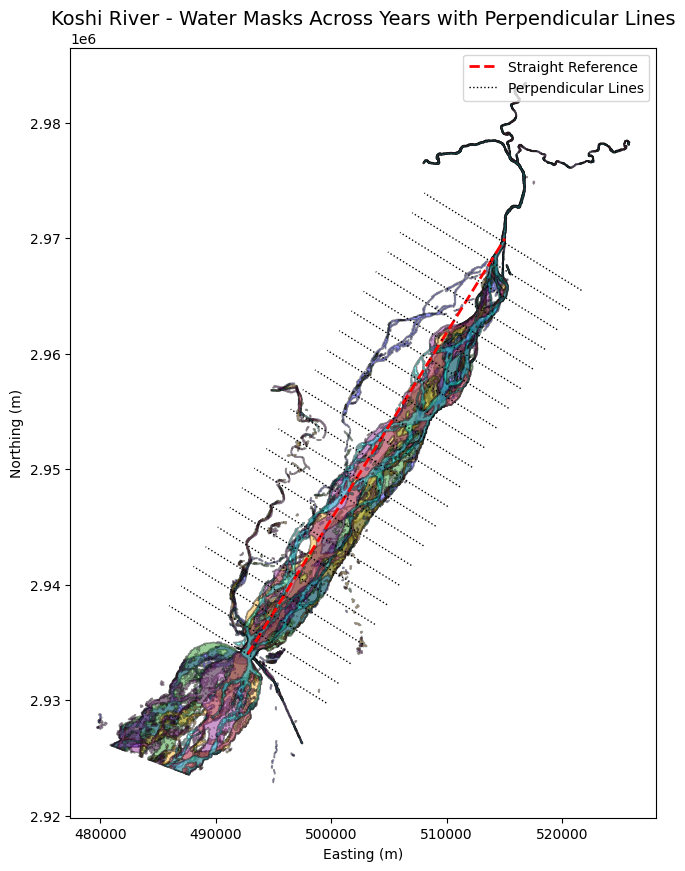

In [10]:
import os
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
import matplotlib.pyplot as plt

folder_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks"
years = [1990, 2000, 2010, 2020, 2024]

# --- Functions ---
def generate_points(line, distance):
    n_points = int(line.length // distance)
    return [line.interpolate(distance*i) for i in range(n_points+1)]

def perpendicular_line(point, line, length=8000):
    d = line.project(point)
    delta = 1
    start = max(d-delta, 0)
    end = min(d+delta, line.length)
    p1 = line.interpolate(start)
    p2 = line.interpolate(end)
    dx = p2.x - p1.x
    dy = p2.y - p1.y
    norm = np.hypot(dx, dy)
    px = -dy/norm
    py = dx/norm
    return LineString([(point.x - px*length, point.y - py*length),
                       (point.x + px*length, point.y + py*length)])

# --- Common CRS ---
target_crs = "EPSG:32645"  # UTM Zone 45N (Nepal)

# --- Load straight line ---
straight_line_gdf = gpd.read_file(os.path.join(folder_path, "straight_line.shp"))
if straight_line_gdf.crs != target_crs:
    straight_line_gdf = straight_line_gdf.to_crs(target_crs)
straight_line = straight_line_gdf.geometry.iloc[0]

# Generate perpendicular lines every 2 km (same for all years)
points = generate_points(straight_line, 2000)
perp_lines = [perpendicular_line(pt, straight_line, length=8000) for pt in points]
gdf_perp = gpd.GeoDataFrame(geometry=perp_lines, crs=target_crs)

# --- Plot all years together ---
fig, ax = plt.subplots(figsize=(14,10))

colors = ['blue', 'green', 'orange', 'purple', 'cyan']

for year, color in zip(years, colors):
    # Load water polygons
    wv = gpd.read_file(os.path.join(folder_path, f"water_vector_{year}.shp"))
    if wv.crs != target_crs:
        wv = wv.to_crs(target_crs)
    
    # Keep only large polygons
    min_area = 1e4  
    wv_large = wv[wv.area >= min_area]
    
    # Plot water mask
    wv_large.plot(ax=ax, color=color, edgecolor='black', alpha=0.4, label=f"Water {year}")

# Add reference lines
straight_line_gdf.plot(ax=ax, color='red', linestyle='--', linewidth=2, label='Straight Reference')
gdf_perp.plot(ax=ax, color='black', linewidth=1, linestyle=':', label='Perpendicular Lines')

# Legend & formatting
plt.legend()
plt.title("Koshi River - Water Masks Across Years with Perpendicular Lines", fontsize=14)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

In [11]:
import os
import geopandas as gpd
from shapely.geometry import LineString
from shapely.ops import unary_union
from shapely.geometry import GeometryCollection, MultiLineString
import numpy as np
import pandas as pd

# --------------------------
# Settings
# --------------------------
folder_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks"
years = [1990, 2000, 2010, 2020, 2024]
target_crs = "EPSG:32645"       # UTM Zone 45N (meters)
interval_m = 2000               # spacing of stations along straight line (2 km)
transect_half_len_m = 8000      # half-length of each perpendicular (total = 16 km)
min_area_keep = 1e4             # filter small polygons (m^2) – adjust as needed

# --------------------------
# Helpers
# --------------------------
def generate_points(line, distance):
    n_points = int(line.length // distance)
    return [line.interpolate(distance * i) for i in range(n_points + 1)]

def perpendicular_line(point, line, half_len):
    """Create a perpendicular line centered at 'point' with total length = 2*half_len."""
    d = line.project(point)
    # small delta to approximate tangent direction
    delta = min(1.0, max(0.0001, 0.001 * line.length))
    p1 = line.interpolate(max(d - delta, 0))
    p2 = line.interpolate(min(d + delta, line.length))
    dx, dy = (p2.x - p1.x, p2.y - p1.y)
    nrm = (dx**2 + dy**2) ** 0.5
    if nrm == 0:
        return None
    # unit perpendicular
    px, py = -dy / nrm, dx / nrm
    return LineString([(point.x - px * half_len, point.y - py * half_len),
                       (point.x + px * half_len, point.y + py * half_len)])

def line_water_segments_lengths(transect_line, water_union):
    """
    Intersect a transect with the dissolved water and return a list of
    segment lengths (each = a channel width along that cross-section).
    """
    inter = transect_line.intersection(water_union)
    lengths = []

    def collect_lengths(geom):
        if geom.is_empty:
            return
        gt = geom.geom_type
        if gt == "LineString":
            lengths.append(geom.length)
        elif gt == "MultiLineString":
            for part in geom.geoms:
                lengths.append(part.length)
        elif gt == "GeometryCollection":
            for part in geom.geoms:
                collect_lengths(part)
        # Points/Polygons don’t represent cross-section widths here, so ignore.

    collect_lengths(inter)
    return [l for l in lengths if l > 0]

# --------------------------
# Load straight line once & unify CRS
# --------------------------
straight_line_gdf = gpd.read_file(os.path.join(folder_path, "straight_line.shp"))
if straight_line_gdf.crs != target_crs:
    straight_line_gdf = straight_line_gdf.to_crs(target_crs)
straight_line = straight_line_gdf.geometry.iloc[0]

# Build perpendicular transects (same stations for all years)
stations = generate_points(straight_line, interval_m)
transects = [perpendicular_line(pt, straight_line, transect_half_len_m) for pt in stations]
# drop any None (degenerate) transects
transects = [t for t in transects if t is not None]

# --------------------------
# Compute H and eBI per transect for each year
# --------------------------
rows = []
for year in years:
    # load water, unify CRS, remove small polygons, dissolve
    wv = gpd.read_file(os.path.join(folder_path, f"water_vector_{year}.shp"))
    if wv.crs != target_crs:
        wv = wv.to_crs(target_crs)
    wv_large = wv[wv.area >= min_area_keep]
    if len(wv_large) == 0:
        water_union = unary_union([])  # empty
    else:
        water_union = unary_union(wv_large.geometry)

    # total water area (km^2) – whole dataset extent, not just on transects
    total_area_km2 = (wv_large.area.sum()) / 1e6

    for idx, tr in enumerate(transects, start=1):
        # widths of all threads at this cross-section
        widths = line_water_segments_lengths(tr, water_union)

        # entropy H and eBI
        if len(widths) == 0:
            H = np.nan
            eBI = np.nan
            N = 0
            W = 0.0
        else:
            W = float(sum(widths))
            probs = np.array(widths, dtype="float64") / W
            # safe entropy in bits; terms with p=0 contribute 0
            H = -np.sum(probs * np.log2(probs))
            eBI = float(2 ** H)
            N = len(widths)

        rows.append({
            "Year": year,
            "Station_ID": idx,
            "Distance_m": interval_m * (idx - 1),
            "N_channels": N,
            "Total_wet_width_m": W,
            "H_bits": H,
            "eBI": eBI,
            "Total_Water_Area_km2": total_area_km2
        })

# --------------------------
# Output tables
# --------------------------
df = pd.DataFrame(rows).sort_values(["Year", "Station_ID"])
df.to_csv(os.path.join(folder_path, "entropy_braiding_per_transect.csv"), index=False)

# Optional: per-year summaries (mean across transects, ignoring NaNs)
summary = (df.groupby("Year", as_index=False)
             .agg(mean_H_bits=("H_bits", "mean"),
                  mean_eBI=("eBI", "mean"),
                  mean_total_wet_width_m=("Total_wet_width_m", "mean"),
                  mean_N_channels=("N_channels", "mean"),
                  Total_Water_Area_km2=("Total_Water_Area_km2", "first")))
summary.to_csv(os.path.join(folder_path, "entropy_braiding_summary_by_year.csv"), index=False)

print("Saved:")
print(" -", os.path.join(folder_path, "entropy_braiding_per_transect.csv"))
print(" -", os.path.join(folder_path, "entropy_braiding_summary_by_year.csv"))


Saved:
 - G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks\entropy_braiding_per_transect.csv
 - G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks\entropy_braiding_summary_by_year.csv


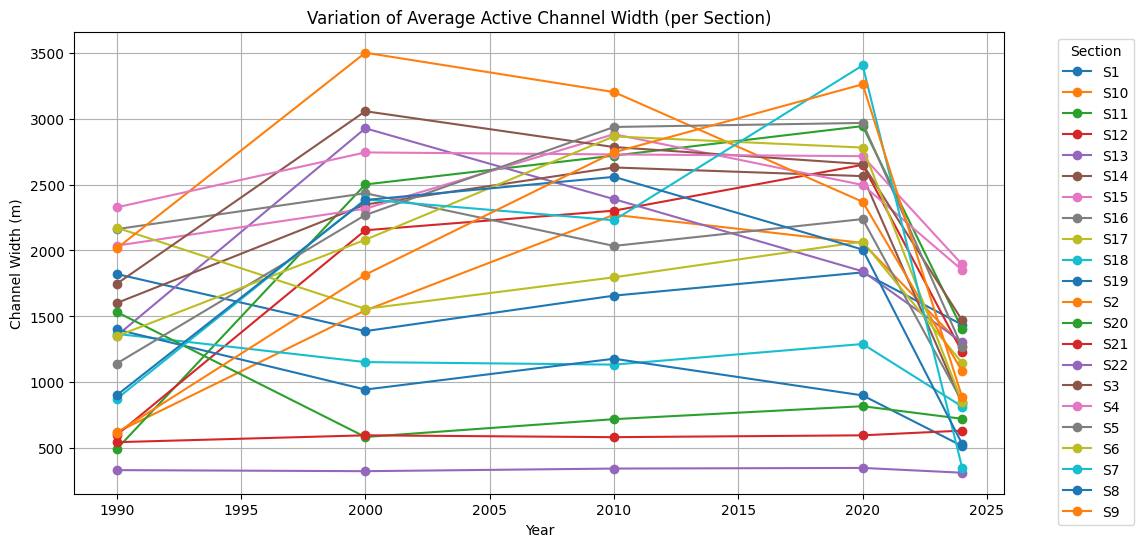

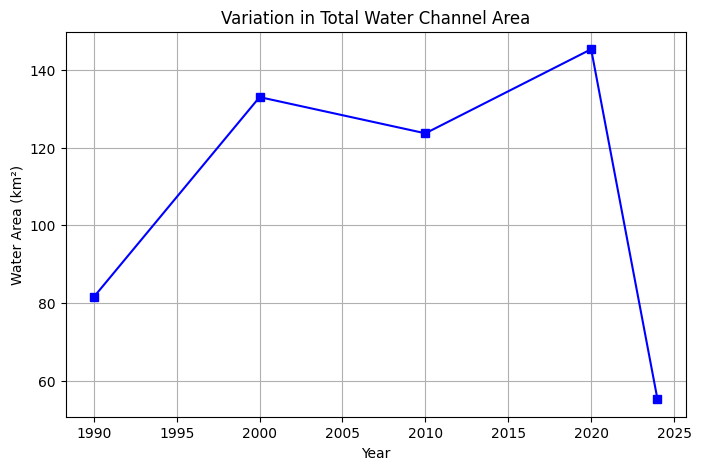

Channel Width Variation per Section (m):
Year     1990         2000        2010         2020         2024
Section                                                         
S1        NaN  -433.239985  269.050393   176.313051  -397.043392
S10       NaN   923.782553  725.264373  -213.457051  -778.465160
S11       NaN  2006.836915  218.781746   223.612100 -1537.649583
S12       NaN  1552.161875  148.593473   347.446973 -1417.974064
S13       NaN  1573.626356 -537.248048  -547.062379  -537.231682
S14       NaN   746.953225  280.991218   -65.587009 -1724.630001
S15       NaN   280.253765  564.792979  -384.961979  -645.002471
S16       NaN   272.180310 -399.448207   203.619417 -1384.430131
S17       NaN  -615.656289  239.415182   270.618378  -920.626487
S18       NaN  -213.828374  -19.288699   156.334793  -474.314660
S19       NaN  -455.799893  233.906192  -278.213527  -383.596730
S2        NaN  1483.921202 -298.328334  -831.984616 -1283.861973
S20       NaN  -947.821151  135.070087    98.2737

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example: read your results (already aggregated per section)
# Replace this with your actual CSV that has columns like:
# ["Year", "Section", "mean_H_bits", "mean_eBI", "mean_total_wet_width_m", "mean_N_channels", "Total_Water_Area_km2"]
df_file_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks\entropy_braiding_per_transect.csv"
df = pd.read_csv(df_file_path)

# Rename Station_ID to section name (S1, S2, …)
df["Section"] = "S" + df["Station_ID"].astype(str)

# 1. Variation of average active channel width
width_variation = df.pivot_table(
    index="Section", columns="Year", values="Total_wet_width_m"
)

# 2. Variation of total water channel area (per year, not section-specific)
area_variation = df.groupby("Year")["Total_Water_Area_km2"].mean()

# --- Plot widths per section ---
plt.figure(figsize=(12,6))
for section in width_variation.index:
    plt.plot(width_variation.columns, width_variation.loc[section],
             marker="o", label=section)

plt.title("Variation of Average Active Channel Width (per Section)")
plt.xlabel("Year")
plt.ylabel("Channel Width (m)")
plt.legend(title="Section", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(True)
plt.show()

# --- Plot water area variation ---
plt.figure(figsize=(8,5))
plt.plot(area_variation.index, area_variation.values, marker="s", color="blue")
plt.title("Variation in Total Water Channel Area")
plt.xlabel("Year")
plt.ylabel("Water Area (km²)")
plt.grid(True)
plt.show()

# Also calculate year-to-year difference
width_change = width_variation.diff(axis=1)   # section-wise differences
area_change = area_variation.diff()           # total area differences

print("Channel Width Variation per Section (m):")
print(width_change)

print("\nWater Channel Area Variation (km²):")
print(area_change)


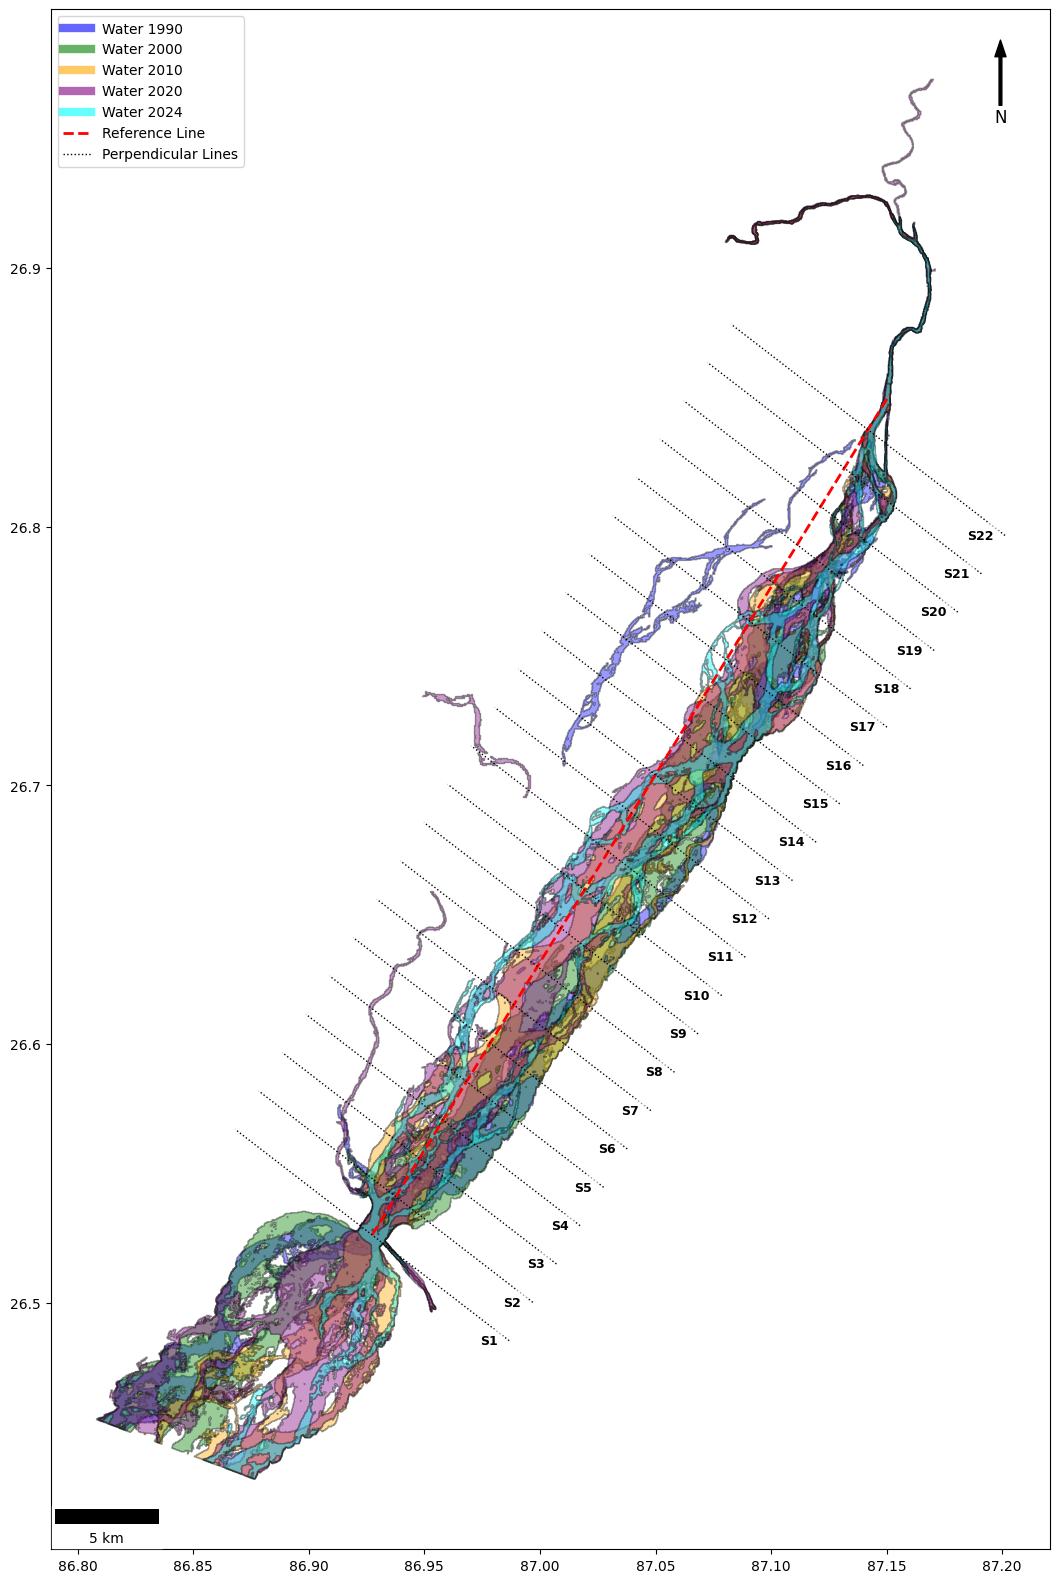

In [50]:
import os
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

folder_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\arc_map\water_masks"
years = [1990, 2000, 2010, 2020, 2024]

# --- Functions ---
def generate_points(line, distance_deg):
    n_points = int(line.length // distance_deg)
    return [line.interpolate(distance_deg*i) for i in range(n_points+1)]

def perpendicular_line(point, line, length_deg=0.072):  # ~8 km in degrees
    d = line.project(point)
    delta = 1e-6
    start = max(d-delta, 0)
    end = min(d+delta, line.length)
    p1 = line.interpolate(start)
    p2 = line.interpolate(end)
    dx = p2.x - p1.x
    dy = p2.y - p1.y
    norm = np.hypot(dx, dy)
    px = -dy/norm
    py = dx/norm
    return LineString([
        (point.x - px*length_deg, point.y - py*length_deg),
        (point.x + px*length_deg, point.y + py*length_deg)
    ])

# --- Common CRS ---
target_crs = "EPSG:4326"  # WGS84 (lat/lon in degrees)

# --- Load straight line ---
straight_line_gdf = gpd.read_file(os.path.join(folder_path, "straight_line.shp"))
if straight_line_gdf.crs != target_crs:
    straight_line_gdf = straight_line_gdf.to_crs(target_crs)
straight_line = straight_line_gdf.geometry.iloc[0]

# Generate perpendicular lines every ~2 km (~0.018 deg)
points = generate_points(straight_line, 0.018)
perp_lines = [perpendicular_line(pt, straight_line, length_deg=0.072) for pt in points]
gdf_perp = gpd.GeoDataFrame(geometry=perp_lines, crs=target_crs)

# --- Plot all years together ---
fig, ax = plt.subplots(figsize=(20,20))

colors = ['blue', 'green', 'orange', 'purple', 'cyan']
handles = []

for year, color in zip(years, colors):
    # Load water polygons
    wv = gpd.read_file(os.path.join(folder_path, f"water_vector_{year}.shp"))
    if wv.crs != target_crs:
        wv = wv.to_crs(target_crs)
    
    # Keep only large polygons
    min_area = 1e-4  # approx degree^2
    wv_large = wv[wv.area >= min_area]
    
    # Plot water mask
    wv_large.plot(ax=ax, color=color, edgecolor='black', alpha=0.4)
    handles.append(plt.Line2D([0], [0], color=color, lw=6, alpha=0.6, label=f"Water {year}"))

# Add reference lines
straight_line_gdf.plot(ax=ax, color='red', linestyle='--', linewidth=2, label='Straight Reference')
gdf_perp.plot(ax=ax, color='black', linewidth=1, linestyle=':', label='Perpendicular Lines')

# --- Add section labels (S1, S2, ...) on the LEFT side ---
for i, line in enumerate(perp_lines, start=1):
    coords = list(line.coords)
    left_point = coords[0]  # take one end (left side)
    ax.text(left_point[0] - 0.005, left_point[1], f"S{i}", fontsize=9, fontweight='bold',
            color='black', ha='right', va='center',
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

# --- North Arrow (pointing UPWARD) ---
ax.annotate('N', xy=(0.95, 0.98), xytext=(0.95, 0.93),
            arrowprops=dict(facecolor='black', width=2, headwidth=8),
            ha='center', va='center', fontsize=12, xycoords='axes fraction')

# --- Scale Bar (approx) ---
# 1 deg latitude ≈ 111 km
scalebar = ScaleBar(111000, location="lower left", units="m")  
ax.add_artist(scalebar)

# Legend & formatting
plt.legend(handles=handles + [
    plt.Line2D([0], [0], color='red', linestyle='--', lw=2, label='Reference Line'),
    plt.Line2D([0], [0], color='black', linestyle=':', lw=1, label='Perpendicular Lines')
], loc="upper left")

plt.title("", fontsize=14)

plt.show()


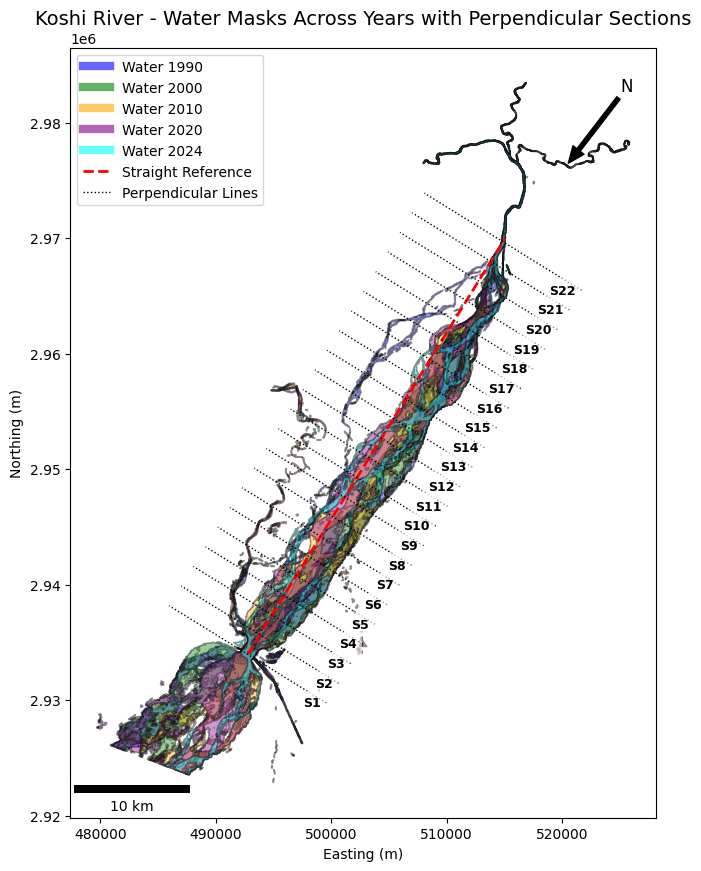

In [ ]:
# ------------------- Parameters -------------------
aoi_path = r"G:\learn\python_works\Work_projects\Koshi_chetan\chetan_cas\works\data\gis\koshi_basin_nepal\koshi_nepal_basin.shp"
years = [1990, 2000, 2010, 2020, 2024]
output_csv = r"G:\learn\python_works\Work_projects\Koshi_chetan\lulc_area_koshi.csv"

# ------------------- Load AOI -------------------
aoi_gdf = gpd.read_file(aoi_path)
aoi_gdf["geometry"] = aoi_gdf.buffer(0)  # fix invalid geometries
aoi_diss = aoi_gdf.dissolve()
aoi = geemap.gdf_to_ee(aoi_diss)

# ------------------- LULC Data -------------------
# We'll use ESA WorldCover for 2020 (10m) and a combination of Landsat-based classification for earlier years
# Here we use MODIS Land Cover for historical LULC (1990-2020)

def get_lulc(year):
    year = int(year)
    if year <= 2020:
        # MODIS Land Cover Type Yearly (MCD12Q1)
        modis = ee.ImageCollection('MODIS/006/MCD12Q1') \
                  .filter(ee.Filter.calendarRange(year, year, 'year')) \
                  .first()
        # Use IGBP classification
        lulc = modis.select('LC_Type1')
    else:
        # For 2024, you can use ESA WorldCover 2020 as approximation
        lulc = ee.Image('ESA/WorldCover/v100/2020').select('Map')
    return lulc.clip(aoi)

# ------------------- Compute area per class -------------------
def compute_area(lulc_image, scale=500):
    # Get counts per class
    pixel_area = ee.Image.pixelArea()
    area_dict = (lulc_image
                 .addBands(pixel_area.rename('area'))
                 .reduceRegion(
                     reducer=ee.Reducer.sum().group(groupField=0, groupName='class'),
                     geometry=aoi,
                     scale=scale,
                     maxPixels=1e13
                 ))
    # Extract values
    results = area_dict.get('groups').getInfo()
    data = {}
    for item in results:
        class_id = item['class']
        area_m2 = item['sum']
        area_km2 = area_m2 / 1e6
        data[class_id] = area_km2
    return data

# ------------------- Loop over years -------------------
all_years = []
for y in years:
    print(f"Processing LULC for {y}...")
    lulc_img = get_lulc(y)
    area_dict = compute_area(lulc_img)
    # Add year column
    for k in area_dict:
        all_years.append({'Year': y, 'Class': k, 'Area_km2': area_dict[k]})

# ------------------- Create DataFrame -------------------
df = pd.DataFrame(all_years)

# Optional: map class IDs to names (example for MODIS IGBP)
modis_igbp = {
    0: 'Water', 1: 'Evergreen Needleleaf Forest', 2: 'Evergreen Broadleaf Forest',
    3: 'Deciduous Needleleaf Forest', 4: 'Deciduous Broadleaf Forest', 5: 'Mixed Forest',
    6: 'Closed Shrublands', 7: 'Open Shrublands', 8: 'Woody Savannas', 9: 'Savannas',
    10: 'Grasslands', 11: 'Permanent Wetlands', 12: 'Croplands', 13: 'Urban and Built-up',
    14: 'Cropland/Natural Vegetation Mosaic', 15: 'Snow and Ice', 16: 'Barren or Sparsely Vegetated'
}
df['Class_Name'] = df['Class'].map(modis_igbp)

# ------------------- Pivot Table for easy comparison -------------------
lulc_table = df.pivot_table(index='Class_Name', columns='Year', values='Area_km2', fill_value=0)
lulc_table = lulc_table.sort_index()
print(lulc_table)

# ------------------- Save to CSV -------------------
lulc_table.to_csv(output_csv)
print(f"LULC area table saved -> {output_csv}")